In [2]:
%load_ext dotenv
%dotenv

import tqdm
import flax
from flax import linen as nn
import jax
from typing import Dict, Callable, Sequence, Any, Union
from dataclasses import field
import jax.numpy as jnp
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import einops
import clu
from clu import parameter_overview, metrics
from flax.training import train_state  # Useful dataclass to keep train state
import optax
from flax import struct                # Flax dataclasses
import time
import os
from datetime import datetime
import orbax
from flax.training import orbax_utils
import numpy as np
from einops import rearrange


2024-07-05 23:58:57.122396: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Initialization

In [3]:
# Some Optimizations
import ctypes

_libcudart = ctypes.CDLL("libcudart.so")
# Set device limit on the current device
# cudaLimitMaxL2FetchGranularity = 0x05
pValue = ctypes.cast((ctypes.c_int * 1)(), ctypes.POINTER(ctypes.c_int))
_libcudart.cudaDeviceSetLimit(ctypes.c_int(0x05), ctypes.c_int(128))
_libcudart.cudaDeviceGetLimit(pValue, ctypes.c_int(0x05))
assert pValue.contents.value == 128
tf.compat.v1.ConfigProto.force_gpu_compatible = True

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1720204137.855038  448620 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1720204137.881732  448620 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1720204137.881868  448620 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1720204137.883123  448620 cuda_executor.cc:1020] successful NUMA node read from SysFS ha

In [4]:
normalizeImage = lambda x: jax.nn.standardize(x, mean=[127.5], std=[127.5])
denormalizeImage = lambda x: (x + 1.0) * 127.5


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(tf.cast(denormalizeImage(imgs[i, :, :, :]), tf.uint8))
        plt.axis("off")
    plt.show()

class RandomClass():
    def __init__(self, rng: jax.random.PRNGKey):
        self.rng = rng

    def get_random_key(self):
        self.rng, subkey = jax.random.split(self.rng)
        return subkey
    
    def set_random_key(self, seed):
        self.rng = jax.random.PRNGKey(seed)

    def reset_random_key(self):
        self.rng = jax.random.PRNGKey(42)

class MarkovState(struct.PyTreeNode):
    pass

class RandomMarkovState(MarkovState):
    rng: jax.random.PRNGKey

    def get_random_key(self):
        rng, subkey = jax.random.split(self.rng)
        return RandomMarkovState(rng), subkey

# Data Pipeline

In [5]:
def get_dataset(data_name="celeb_a", batch_size=64, image_scale=256):
    def augmenter(image_scale=256, method="area"):
        @tf.function()
        def augment(sample):
            image = (
                tf.cast(sample["image"], tf.float32) - 127.5
            ) / 127.5
            image = tf.image.resize(
                image, [image_scale, image_scale], method=method, antialias=True
            )
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_contrast(image, 0.999, 1.05)
            image = tf.image.random_brightness(image, 0.2)

            image = tf.clip_by_value(image, -1.0, 1.0)
            return image
        return augment

    # Load CelebA Dataset
    data: tf.data.Dataset = tfds.load(data_name, split="all", shuffle_files=True)
    final_data = (
        data
        .cache()  # Cache after augmenting to avoid recomputation
        # .prefetch(tf.data.experimental.AUTOTUNE)
        # .batch(128, num_parallel_calls=tf.data.AUTOTUNE)
        .map(
            augmenter(image_scale, method="area"),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        .repeat()  # Repeats the dataset indefinitely
        # .unbatch()
        .shuffle(4096)  # Ensure this is adequate for your dataset size
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
    ).as_numpy_iterator()
    return final_data, len(data)


# Noise Samplers

In [6]:
def cosine_beta_schedule(timesteps, start_angle=0.008, end_angle=0.999):
    ts = np.linspace(0, 1, timesteps + 1, dtype=np.float64)
    alphas_bar = np.cos((ts + start_angle) / (1 + start_angle) * np.pi /2) ** 2
    alphas_bar = alphas_bar/alphas_bar[0]
    betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
    return np.clip(betas, 0, end_angle)

def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    scale = 1000 / timesteps
    beta_start = scale * beta_start
    beta_end = scale * beta_end
    betas = np.linspace(
        beta_start, beta_end, timesteps, dtype=np.float64)
    return betas

class NoiseScheduler():
    def __init__(self, timesteps,
                    dtype=jnp.float32,
                    clip_min=-1.0,
                    clip_max=1.0,
                    *args, **kwargs):
        self.max_timesteps = timesteps
        self.dtype = dtype
        self.clip_min = clip_min
        self.clip_max = clip_max

    def generate_timesteps(self, batch_size, state:RandomMarkovState) -> tuple[jnp.ndarray, RandomMarkovState]:
        raise NotImplementedError
    
    def get_p2_weights(self, k, gamma):
        raise NotImplementedError
    
    def clip_images(self, images) -> jnp.ndarray:
        raise NotImplementedError
    
    def reshape_rates(self, rates:tuple[jnp.ndarray, jnp.ndarray]) -> tuple[jnp.ndarray, jnp.ndarray]:
        raise NotImplementedError
    
    def get_rates(self, steps):
        raise NotImplementedError
    
    def add_noise(self, images, noise, steps, rates=None) -> jnp.ndarray:
        raise NotImplementedError
    
    def remove_all_noise(self, noisy_images, noise, steps, clip_denoised=True, rates=None):
        raise NotImplementedError
    
    def transform_steps(self, steps):
        raise NotImplementedError
    
    def get_posterior_mean(self, x_0, x_t, steps):
        raise NotImplementedError
    
    def get_posterior_variance(self, steps):
        raise NotImplementedError
    

class DiscreteNoiseScheduler(NoiseScheduler):
    def __init__(self, timesteps,
                    beta_start=0.0001,
                    beta_end=0.02,
                    schedule_fn=linear_beta_schedule, 
                    *args, **kwargs):
        super().__init__(timesteps, *args, **kwargs)
        betas = schedule_fn(timesteps, beta_start, beta_end)
        alphas = 1 - betas
        alpha_cumprod = jnp.cumprod(alphas, axis=0)
        alpha_cumprod_prev = jnp.append(1.0, alpha_cumprod[:-1])
        
        self.betas = jnp.array(betas, dtype=jnp.float32)
        self.alphas = alphas.astype(jnp.float32)
        self.alpha_cumprod = alpha_cumprod.astype(jnp.float32)
        self.alpha_cumprod_prev = alpha_cumprod_prev.astype(jnp.float32)

        self.sqrt_alpha_cumprod = jnp.sqrt(alpha_cumprod).astype(jnp.float32)
        self.sqrt_one_minus_alpha_cumprod = jnp.sqrt(1 - alpha_cumprod).astype(jnp.float32)

        self.sqrt_recip_alpha_cumprod = jnp.sqrt(1 / alpha_cumprod).astype(jnp.float32)
        self.sqrt_recip_one_minus_alpha_cumprod = jnp.sqrt(1 / alpha_cumprod - 1).astype(jnp.float32)

        posterior_variance = (betas * (1 - alpha_cumprod_prev) / (1 - alpha_cumprod))
        self.posterior_variance = posterior_variance.astype(jnp.float32)
        self.posterior_log_variance_clipped = (jnp.log(jnp.maximum(posterior_variance, 1e-20))).astype(jnp.float32)
        
        self.posterior_mean_coef1 = (betas * jnp.sqrt(alpha_cumprod_prev) / (1 - alpha_cumprod)).astype(jnp.float32)
        self.posterior_mean_coef2 = ((1 - alpha_cumprod_prev) * jnp.sqrt(alphas) / (1 - alpha_cumprod)).astype(jnp.float32)

    def generate_timesteps(self, batch_size, state:RandomMarkovState) -> tuple[jnp.ndarray, RandomMarkovState]:
        state, rng = state.get_random_key()
        timesteps = jax.random.randint(rng, (batch_size,), 0, self.max_timesteps)
        return timesteps, state
    
    def get_p2_weights(self, k, gamma):
        return (k + self.alpha_cumprod / (1 - self.alpha_cumprod)) ** -gamma
    
    def clip_images(self, images) -> jnp.ndarray:
        return jnp.clip(images, self.clip_min, self.clip_max)
    
    def reshape_rates(self, rates:tuple[jnp.ndarray, jnp.ndarray]) -> tuple[jnp.ndarray, jnp.ndarray]:
        signal_rates, noise_rates = rates
        signal_rates = jnp.reshape(signal_rates, (-1, 1, 1, 1))
        noise_rates = jnp.reshape(noise_rates, (-1, 1, 1, 1))
        return signal_rates, noise_rates

    def get_rates(self, steps):
        signal_rate = self.sqrt_alpha_cumprod[steps]
        noise_rate = self.sqrt_one_minus_alpha_cumprod[steps]
        signal_rate = jnp.reshape(signal_rate, (-1, 1, 1, 1))
        noise_rate = jnp.reshape(noise_rate, (-1, 1, 1, 1))
        return signal_rate, noise_rate
    
    # Used while training
    def add_noise(self, images, noise, steps) -> jnp.ndarray:
        signal_rates, noise_rates = self.get_rates(steps)
        return signal_rates * images + noise_rates * noise

    def remove_all_noise(self, noisy_images, noise, steps):
        # Scale 't' to the range [0, 1]
        signal_coeff = self.sqrt_recip_alpha_cumprod[steps]
        noise_coeff = self.sqrt_recip_one_minus_alpha_cumprod[steps]
        signal_coeff, noise_coeff = self.reshape_rates((signal_coeff, noise_coeff))
        pred_images = signal_coeff * noisy_images - noise_coeff * noise
        return pred_images
    
    # Used while training
    def transform_steps(self, steps):
        return steps #/ self.max_timesteps
    
    def get_posterior_mean(self, x_0, x_t, steps):
        x_0_coeff = self.posterior_mean_coef1[steps]
        x_t_coeff = self.posterior_mean_coef2[steps]
        x_0_coeff, x_t_coeff = self.reshape_rates((x_0_coeff, x_t_coeff))
        mean = x_0_coeff * x_0 + x_t_coeff * x_t
        return mean
    
    def get_posterior_variance(self, steps):
        return jnp.exp(0.5 * self.posterior_log_variance_clipped[steps]).reshape(-1, 1, 1, 1)

class CosineNoiseScheduler(DiscreteNoiseScheduler):
    def __init__(self, timesteps, beta_start=0.008, beta_end=0.999, *args, **kwargs):
        super().__init__(timesteps, beta_start, beta_end, schedule_fn=cosine_beta_schedule, *args, **kwargs)

class LinearNoiseSchedule(DiscreteNoiseScheduler):
    def __init__(self, timesteps, beta_start=0.0001, beta_end=0.02, *args, **kwargs):
        super().__init__(timesteps, beta_start, beta_end, schedule_fn=linear_beta_schedule, *args, **kwargs)

############################################################################################################
# Prediction Transforms
############################################################################################################

class DiffusionPredictionTransform():
    def __call__(self, x_t, preds, current_step, noise_schedule:NoiseScheduler) -> Union[jnp.ndarray, jnp.ndarray]:
        raise NotImplementedError
    
    def get_target(self, x_0, epsilon, current_step, rates) ->jnp.ndarray:
        raise NotImplementedError
    
    def train_step(self, x_0, epsilon, current_step, noise_schedule:NoiseScheduler) -> Union[jnp.ndarray, jnp.ndarray]:
        signal_rate, noise_rate = noise_schedule.get_rates(current_step)
        x_t = signal_rate * x_0 + noise_rate * epsilon
        expected_output = self.get_target(x_0, epsilon, current_step, (signal_rate, noise_rate))
        return x_t, expected_output
    
class EpsilonPredictionTransform(DiffusionPredictionTransform):
    def __call__(self, x_t, preds, current_step, noise_schedule:NoiseScheduler) -> Union[jnp.ndarray, jnp.ndarray]:
        # preds is the predicted noise
        epsilon = preds
        x_0 = noise_schedule.remove_all_noise(x_t, epsilon, current_step)
        return x_0, epsilon
    
    def get_target(self, x_0, epsilon, current_step, rates) ->jnp.ndarray:
        return epsilon
    
class VPredictionTransform(DiffusionPredictionTransform):
    def __call__(self, x_t, preds, current_step, noise_schedule:NoiseScheduler) -> Union[jnp.ndarray, jnp.ndarray]:
        # here the model output's V = sqrt_alpha_t * epsilon - sqrt_one_minus_alpha_t * x_0
        # where epsilon is the noise
        # x_0 is the current sample
        v = preds
        signal_rate, noise_rate = noise_schedule.get_rates(current_step)
        x_0 = signal_rate * x_t - noise_rate * v
        eps_0 = signal_rate * v + noise_rate * x_t
        return x_0, eps_0
    
    def get_target(self, x_0, epsilon, current_step, rates) ->jnp.ndarray:
        signal_rate, noise_rate = rates
        return signal_rate * epsilon - noise_rate * x_0

# Data Diffusion Testing

In [ ]:
# Visualize adding some noise to some sample images and then removing it
state = RandomMarkovState(jax.random.PRNGKey(4))
data, _ = get_dataset("oxford_flowers102", batch_size=64, image_scale=64)
images = next(iter(data))
plotImages(images)
noise_level = 400# * jnp.ones((images.shape[0], ), dtype=jnp.int32)
noise_level_max = 1000
schedule = CosineNoiseScheduler(noise_level_max)
state, rng = state.get_random_key()
noise = jax.random.normal(rng, shape=images.shape, dtype=jnp.float64)
noisy_images = schedule.add_noise(images, noise, noise_level)
plotImages(noisy_images)
plotImages(noise)
reconstructed_images = schedule.remove_all_noise(noisy_images, noise, noise_level)
plotImages(reconstructed_images)


# Modeling

## Metrics

## Callbacks

## Model Generator

In [7]:
# Built using the Flax NNX library

# Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return nn.initializers.variance_scaling(scale=scale, mode="fan_in", distribution="truncated_normal")

class WeightStandardizedConv(nn.Module):
    """
    apply weight standardization  https://arxiv.org/abs/1903.10520
    """
    features: int
    kernel_size: Sequence[int] = 3
    strides: Union[None, int, Sequence[int]] = 1
    padding: Any = 1
    dtype: Any = jnp.float32
    param_dtype: Any = jnp.float32


    @nn.compact
    def __call__(self, x):
        """
        Applies a weight standardized convolution to the inputs.

        Args:
          inputs: input data with dimensions (batch, spatial_dims..., features).

        Returns:
          The convolved data.
        """
        x = x.astype(self.dtype)

        conv = nn.Conv(
            features=self.features,
            kernel_size=self.kernel_size,
            strides = self.strides,
            padding=self.padding,
            dtype=self.dtype,
            param_dtype = self.param_dtype,
            parent=None)

        kernel_init = lambda  rng, x: conv.init(rng,x)['params']['kernel']
        bias_init = lambda  rng, x: conv.init(rng,x)['params']['bias']

        # standardize kernel
        kernel = self.param('kernel', kernel_init, x)
        eps = 1e-5 if self.dtype == jnp.float32 else 1e-3
        # reduce over dim_out
        redux = tuple(range(kernel.ndim - 1))
        mean = jnp.mean(kernel, axis=redux, dtype=self.dtype, keepdims=True)
        var = jnp.var(kernel, axis=redux, dtype=self.dtype, keepdims=True)
        standardized_kernel = (kernel - mean)/jnp.sqrt(var + eps)

        bias = self.param('bias',bias_init, x)

        return(conv.apply({'params': {'kernel': standardized_kernel, 'bias': bias}},x))

class PixelShuffle(nn.Module):
    scale: int

    @nn.compact
    def __call__(self, x):
        up = einops.rearrange(
            x,
            pattern="b h w (h2 w2 c) -> b (h h2) (w w2) c",
            h2=self.scale,
            w2=self.scale,
        )
        return up

class TimeEmbedding(nn.Module):
    features:int
    max_timesteps:int=10000

    def setup(self):
        # self.embeddings = nn.Embed(
        #     num_embeddings=max_timesteps, features=out_features
        # )
        half_dim = self.features // 2
        emb = jnp.log(self.max_timesteps) / (half_dim - 1)
        emb = jnp.exp(-emb * jnp.arange(half_dim, dtype=jnp.float32))
        self.embeddings = emb

    def __call__(self, x):
        x = jax.lax.convert_element_type(x, jnp.float32)
        emb = x[:, None] * self.embeddings[None, :]
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
        return emb

class TimeProjection(nn.Module):
    features:int
    activation:Callable=jax.nn.gelu

    @nn.compact
    def __call__(self, x):
        x = nn.DenseGeneral(self.features, kernel_init=kernel_init(1.0))(x)
        x = self.activation(x)
        x = nn.DenseGeneral(self.features, kernel_init=kernel_init(1.0))(x)
        x = self.activation(x)
        return x

class SeparableConv(nn.Module):
    features:int
    kernel_size:tuple=(3, 3)
    strides:tuple=(1, 1)
    use_bias:bool=False
    kernel_init:Callable=kernel_init(1.0)
    padding:str="SAME"

    @nn.compact
    def __call__(self, x):
        in_features = x.shape[-1]
        depthwise = nn.Conv(
            features=in_features, kernel_size=self.kernel_size,
            strides=self.strides, kernel_init=self.kernel_init,
            feature_group_count=in_features, use_bias=self.use_bias,
            padding=self.padding
        )(x)
        pointwise = nn.Conv(
            features=self.features, kernel_size=(1, 1),
            strides=(1, 1), kernel_init=self.kernel_init,
            use_bias=self.use_bias
        )(depthwise)
        return pointwise


class ConvLayer(nn.Module):
    conv_type:str
    features:int
    kernel_size:tuple=(3, 3)
    strides:tuple=(1, 1)
    kernel_init:Callable=kernel_init(1.0)

    def setup(self):
        # conv_type can be "conv", "separable", "conv_transpose"
        if self.conv_type == "conv":
            self.conv = nn.Conv(
                features=self.features,
                kernel_size=self.kernel_size,
                strides=self.strides,
                kernel_init=self.kernel_init,
            )
        elif self.conv_type == "w_conv":
            self.conv = WeightStandardizedConv(
                features=self.features,
                kernel_size=self.kernel_size,
                strides=self.strides,
                padding="SAME",
                dtype=jnp.float32,
                param_dtype=jnp.float32
            )
        elif self.conv_type == "separable":
            self.conv = SeparableConv(
                features=self.features,
                kernel_size=self.kernel_size,
                strides=self.strides,
                kernel_init=self.kernel_init,
            )
        elif self.conv_type == "conv_transpose":
            self.conv = nn.ConvTranspose(
                features=self.features,
                kernel_size=self.kernel_size,
                strides=self.strides,
                kernel_init=self.kernel_init,
            )

    def __call__(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    features:int
    scale:int
    activation:Callable=jax.nn.swish

    @nn.compact
    def __call__(self, x, residual=None):
        out = x
        # out = PixelShuffle(scale=self.scale)(out)
        B, H, W, C = x.shape
        out = jax.image.resize(x, (B, H * self.scale, W * self.scale, C), method="nearest")
        out = ConvLayer(
            "conv",
            features=self.features,
            kernel_size=(3, 3),
            strides=(1, 1),
        )(out)
        if residual is not None:
            out = jnp.concatenate([out, residual], axis=-1)
        return out

class Downsample(nn.Module):
    features:int
    scale:int
    activation:Callable=jax.nn.swish

    @nn.compact
    def __call__(self, x, residual=None):
        out = ConvLayer(
            "conv",
            features=self.features,
            kernel_size=(4, 4),
            strides=(2, 2)
        )(x)
        if residual is not None:
            if residual.shape[1] > out.shape[1]:
                residual = nn.avg_pool(residual, window_shape=(2, 2), strides=(2, 2), padding="SAME")
            out = jnp.concatenate([out, residual], axis=-1)
        return out


class ResidualBlock(nn.Module):
    conv_type:str
    features:int
    kernel_size:tuple=(3, 3)
    strides:tuple=(1, 1)
    padding:str="SAME"
    activation:Callable=jax.nn.swish
    direction:str=None
    res:int=2
    norm_groups:int=8
    kernel_init:Callable=kernel_init(1.0)

    @nn.compact
    def __call__(self, x:jax.Array, temb:jax.Array, extra_features:jax.Array=None):
        residual = x
        out = nn.GroupNorm(8)(x)
        out = self.activation(out)

        out = ConvLayer(
            self.conv_type,
            features=self.features,
            kernel_size=self.kernel_size,
            strides=self.strides,
            kernel_init=self.kernel_init,
            name="conv1"
        )(out)
        out = nn.GroupNorm(8)(out)

        temb = nn.DenseGeneral(features=self.features*2, name="temb_projection")(temb)[:, None, None, :]
        scale, shift = jnp.split(temb, 2, axis=-1)
        out = out * (1 + scale) + shift

        out = self.activation(out)

        out = ConvLayer(
            self.conv_type,
            features=self.features,
            kernel_size=self.kernel_size,
            strides=self.strides,
            kernel_init=self.kernel_init,
            name="conv2"
        )(out)

        if residual.shape != out.shape:
            residual = ConvLayer(
                self.conv_type,
                features=self.features,
                kernel_size=(1, 1),
                strides=1,
                kernel_init=self.kernel_init,
                name="residual_conv"
            )(residual)
        out = out + residual

        out = jnp.concatenate([out, extra_features], axis=-1) if extra_features is not None else out

        return out

class Unet(nn.Module):
    emb_features:int=64*4,
    feature_depths:list=[64, 128, 256, 512],
    attention_configs:list=[{"heads":8}, {"heads":8}, {"heads":8}, {"heads":8}],
    num_res_blocks:int=2,
    num_middle_res_blocks:int=1,
    activation:Callable = jax.nn.swish

    @nn.compact
    def __call__(self, x, temb):
        # print("embedding features", self.emb_features)
        temb = TimeEmbedding(features=self.emb_features)(temb)
        temb = TimeProjection(features=self.emb_features)(temb)
        # print("time embedding", temb.shape)
        feature_depths = self.feature_depths
        attention_configs = self.attention_configs
        x = ConvLayer(
            "conv",
            features=self.feature_depths[0],
            kernel_size=(7, 7),
            strides=(1, 1),
            kernel_init=kernel_init(1.0)
        )(x)
        downs = [x]

        # Downscaling blocks
        for i, (dim_out, attention_config) in enumerate(zip(feature_depths, attention_configs)):
            dim_in = x.shape[-1]
            # dim_in = dim_out
            for j in range(self.num_res_blocks):
                x = ResidualBlock(
                    "conv",
                    name=f"down_{i}_residual_{j}",
                    features=dim_in,
                    kernel_init=kernel_init(1.0),
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation=self.activation,
                )(x, temb)
                # print("down residual for feature level", i, "is of shape", x.shape, "features", dim_in)
                downs.append(x)
            if i != len(feature_depths) - 1:
                # print("Downsample", i, x.shape)
                x = Downsample(
                    features=dim_out,
                    scale=2,
                    activation=self.activation,
                    name=f"down_{i}_downsample"
                )(x)

        # Middle Blocks
        middle_dim_out = self.feature_depths[-1]
        middle_attention = self.attention_configs[-1]
        x = ConvLayer(
            "conv",
            features=middle_dim_out,
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_init=kernel_init(1.0),
            name="middle_conv"
        )(x)
        for j in range(self.num_middle_res_blocks):
            x = ResidualBlock(
                "conv",
                name=f"middle_res1_{j}",
                features=middle_dim_out,
                kernel_init=kernel_init(1.0),
                kernel_size=(3, 3),
                strides=(1, 1),
                activation=self.activation,
            )(x, temb)
            x = ResidualBlock(
                "conv",
                name=f"middle_res2_{j}",
                features=middle_dim_out,
                kernel_init=kernel_init(1.0),
                kernel_size=(3, 3),
                strides=(1, 1),
                activation=self.activation,
            )(x, temb)

        # Upscaling Blocks
        for i, (dim_out, attention_config) in enumerate(zip(reversed(feature_depths), reversed(attention_configs))):
            # print("Upscaling", i, "features", dim_out)
            for j in range(self.num_res_blocks):
                x = jnp.concatenate([x, downs.pop()], axis=-1)
                # print("concat==> ", i, "concat", x.shape)
                # kernel_size = (1 + 2 * (j + 1), 1 + 2 * (j + 1))
                kernel_size = (3, 3)
                x = ResidualBlock(
                    "conv",
                    name=f"up_{i}_residual_{j}",
                    features=dim_out,
                    kernel_init=kernel_init(1.0),
                    kernel_size=kernel_size,
                    strides=(1, 1),
                    activation=self.activation,
                )(x, temb)
            # print("Upscaling ", i, x.shape)
            if i != len(feature_depths) - 1:
                x = Upsample(
                    features=feature_depths[-i],
                    scale=2,
                    activation=self.activation,
                    name=f"up_{i}_upsample"
                )(x)
        
        x = ConvLayer(
            "conv",
            features=self.feature_depths[0],
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_init=kernel_init(0.0)
        )(x)
    
        x = jnp.concatenate([x, downs.pop()], axis=-1)

        x = ResidualBlock(
            "conv",
            name="final_residual",
            features=self.feature_depths[0],
            kernel_init=kernel_init(1.0),
            kernel_size=(3, 3),
            strides=(1, 1),
            activation=self.activation,
        )(x, temb)

        print(downs)

        x = nn.GroupNorm(8)(x)
        x = self.activation(x)

        noise_out = ConvLayer(
            "conv",
            features=3,
            kernel_size=(1, 1),
            strides=(1, 1),
            # activation=jax.nn.mish
            kernel_init=kernel_init(0.0)
        )(x)
        return noise_out#, attentions

In [8]:
# model = Unet(emb_features=256,
#     feature_depths=[64, 128, 256, 512],
#     attention_configs=[{"heads":4}, {"heads":4}, {"heads":4}, {"heads":4}],
#     num_res_blocks=2,
#     num_middle_res_blocks=1)
# inp = jnp.ones((1, 64, 64, 3))
# temb = jnp.ones((1,))
# print(model.tabulate(jax.random.key(0), inp, temb, console_kwargs={"width": 200, "force_jupyter":True, }))


# Training

In [9]:
BATCH_SIZE = 16
IMAGE_SIZE = 64

cosine_schedule = CosineNoiseScheduler(1000, beta_end=1)
linear_schedule = LinearNoiseSchedule(1000)

In [10]:
import orbax.checkpoint


@struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output('loss') # type: ignore

class ModelState():
    model: nn.Module
    params: dict
    noise_schedule: NoiseScheduler
    model_output_transform: DiffusionPredictionTransform

class TrainState(train_state.TrainState):
    rngs:jax.random.PRNGKey
    
    def get_random_key(self):
        rngs, subkey = jax.random.split(self.rngs)
        return self.replace(rngs=rngs), subkey

class DiffusionTrainer:
    state : TrainState
    best_state : TrainState
    best_loss : float
    model : nn.Module
    noise_schedule : NoiseScheduler
    model_output_transform:DiffusionPredictionTransform
    
    def __init__(self, 
                 model:nn.Module, 
                 optimizer: optax.GradientTransformation,
                 noise_schedule:NoiseScheduler,
                 rngs:jax.random.PRNGKey,
                 train_state:TrainState=None,
                 name:str="Diffusion",
                 load_from_checkpoint:bool=False,
                 p2_loss_weight_k:float=1,
                 p2_loss_weight_gamma:float=1,
                 param_transforms:Callable=None,
                 model_output_transform:DiffusionPredictionTransform=EpsilonPredictionTransform()
                 ):
        self.model = model
        self.noise_schedule = noise_schedule
        self.name = name
        self.p2_loss_weights = self.noise_schedule.get_p2_weights(p2_loss_weight_k, p2_loss_weight_gamma)
        self.model_output_transform = model_output_transform

        checkpointer = orbax.checkpoint.PyTreeCheckpointer()
        options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=4, create=True)
        self.checkpointer = orbax.checkpoint.CheckpointManager(self.checkpoint_path(), checkpointer, options)

        if load_from_checkpoint:
            params = self.load()
        else:
            params = None

        if train_state == None:
            self.init_state(optimizer, rngs, params=params, model=model, param_transforms=param_transforms)
        else:
            train_state.params = params
            self.state = train_state
            self.best_state = train_state

    def init_state(self, 
                   optimizer: optax.GradientTransformation, 
                   rngs:jax.random.PRNGKey,
                   params:dict=None,
                   model:nn.Module=None,
                     param_transforms:Callable=None,
                   ):
        inp = jnp.ones((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
        temb = jnp.ones((BATCH_SIZE,))
        rngs, subkey = jax.random.split(rngs)
        if params == None:
            params = model.init(subkey, inp, temb)
        if param_transforms is not None:
            params = param_transforms(params)
        self.best_loss = 1e9
        self.state = TrainState.create(
            apply_fn=model.apply,
            params=params,
            tx=optimizer,
            rngs=rngs,
        )
        self.best_state = self.state

    def checkpoint_path(self):
        experiment_name = self.name
        path = os.path.join(os.path.abspath('./models'), experiment_name)
        if not os.path.exists(path):
            os.makedirs(path)
        return path

    def load(self):
        step = self.checkpointer.latest_step()
        print("Loading model from checkpoint", step)
        ckpt = self.checkpointer.restore(step)
        state = ckpt['state']
        # Convert the state to a TrainState
        self.best_loss = ckpt['best_loss']
        print(f"Loaded model from checkpoint at step {step}", ckpt['best_loss'])
        return state.get('params', None)#, ckpt.get('model', None)

    def save(self, epoch=0, best=False):
        print(f"Saving model at epoch {epoch}")
        state = self.best_state if best else self.state
        # filename = os.path.join(self.checkpoint_path(), f'model_{epoch}' if not best else 'best_model')
        ckpt = {
            'model': self.model,
            'state': state,
            'best_loss': self.best_loss
        }
        save_args = orbax_utils.save_args_from_target(ckpt)
        self.checkpointer.save(epoch, ckpt, save_kwargs={'save_args': save_args})

    def summary(self):
        inp = jnp.ones((1, IMAGE_SIZE, IMAGE_SIZE, 3))
        temb = jnp.ones((1,))
        print(self.model.tabulate(jax.random.key(0), inp, temb, console_kwargs={"width": 200, "force_jupyter":True, }))

    def _define_train_step(self):
        noise_schedule = self.noise_schedule
        model = self.model
        p2_loss_weights = self.p2_loss_weights
        model_output_transform = self.model_output_transform
        @jax.jit
        def train_step(state:TrainState, batch):
            """Train for a single step."""
            images = batch
            noise_level, state = noise_schedule.generate_timesteps(images.shape[0], state)
            state, rngs = state.get_random_key()
            noise:jax.Array = jax.random.normal(rngs, shape=images.shape)
            noisy_images, expected_output = model_output_transform.train_step(images, noise, noise_level, noise_schedule)
            def loss_fn(params):
                preds = model.apply(params, noisy_images, noise_schedule.transform_steps(noise_level))
                nloss = jnp.mean(optax.l2_loss(preds.reshape((1, -1)) - expected_output.reshape((1, -1))), axis=1)
                nloss *= p2_loss_weights[noise_level]
                nloss = jnp.mean(nloss)
                loss = nloss
                return loss
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads) 
            return state, loss
        return train_step
    
    def _define_compute_metrics(self):
        @jax.jit
        def compute_metrics(state:TrainState, expected, pred):
            loss = jnp.mean(jnp.square(pred - expected))
            metric_updates = state.metrics.single_from_model_output(loss=loss)
            metrics = state.metrics.merge(metric_updates)
            state = state.replace(metrics=metrics)
            return state
        return compute_metrics

    def fit(self, data, steps_per_epoch, epochs):
        data = iter(data)
        train_step = self._define_train_step()
        compute_metrics = self._define_compute_metrics()
        state = self.state
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            start_time = time.time()
            epoch_loss = 0
            with tqdm.tqdm(total=steps_per_epoch, desc=f'\t\tEpoch {epoch+1}', ncols=100, unit='step') as pbar:
                for i in range(steps_per_epoch):
                    batch = next(data)
                    state, loss = train_step(state, batch)
                    epoch_loss += loss
                    if i % 100 == 0:
                        pbar.set_postfix(loss=f'{loss:.4f}')
                        pbar.update(100)
            end_time = time.time()
            self.state = state
            total_time = end_time - start_time
            avg_time_per_step = total_time / steps_per_epoch
            avg_loss = epoch_loss / steps_per_epoch
            if avg_loss < self.best_loss:
                self.best_loss = avg_loss
                self.best_state = state
                self.save(epoch, best=True)
            print(f"\n\tEpoch {epoch+1} completed. Avg Loss: {avg_loss}, Time: {total_time:.2f}s, Best Loss: {self.best_loss}")
        return self.state


In [12]:
# experiment_name = "{name}_{date}".format(
#     name="Diffusion", date=datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
# )
experiment_name = '../Diffusion_2024-06-14_10:46:35'
print("Experiment_Name:", experiment_name)
unet = Unet(emb_features=256, 
            feature_depths=[64, 128, 256, 512],
            attention_configs=[{"heads":4}, {"heads":4}, {"heads":4}, {"heads":4}],
            num_res_blocks=2,
            num_middle_res_blocks=1
)
# solver = optax.lookahead(optax.adam(2e-4), sync_period=6, slow_step_size=0.5)
# params_transform = lambda x: optax.LookaheadParams.init_synced(x)
solver = optax.adam(2e-4)
trainer = DiffusionTrainer(unet, optimizer=solver, 
                           noise_schedule=cosine_schedule,
                           rngs=jax.random.PRNGKey(4), 
                           name=experiment_name,
                           model_output_transform=VPredictionTransform(),
                            # param_transforms=params_transform,
                           load_from_checkpoint=True,
                           )
#trainer.summary()

Experiment_Name: ../Diffusion_2024-06-14_10:46:35
Loading model from checkpoint 753
Loaded model from checkpoint at step 753 0.026390791


In [ ]:
trainer.summary()

In [24]:
data, datalen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
final_state = trainer.fit(data, datalen // BATCH_SIZE, epochs=1000)

		Epoch 997: 600step [00:21, 27.64step/s, loss=0.0266]                                              



	Epoch 997 completed. Avg Loss: 0.02738419733941555, Time: 21.71s, Best Loss: 0.026390790939331055

Epoch 998/1000


		Epoch 998: 600step [00:21, 27.66step/s, loss=0.0168]                                              



	Epoch 998 completed. Avg Loss: 0.026708658784627914, Time: 21.70s, Best Loss: 0.026390790939331055

Epoch 999/1000


		Epoch 999: 600step [00:21, 27.78step/s, loss=0.0281]                                              



	Epoch 999 completed. Avg Loss: 0.027463030070066452, Time: 21.60s, Best Loss: 0.026390790939331055

Epoch 1000/1000


		Epoch 1000: 600step [00:21, 27.74step/s, loss=0.0236]                                             


	Epoch 1000 completed. Avg Loss: 0.027076976373791695, Time: 21.63s, Best Loss: 0.026390790939331055


In [13]:
class DiffusionSampler():
    model:nn.Module
    noise_schedule:NoiseScheduler
    params:dict
    model_output_transform:DiffusionPredictionTransform

    def __init__(self, model:nn.Module, params:dict,  
                 noise_schedule:NoiseScheduler, 
                 model_output_transform:DiffusionPredictionTransform=EpsilonPredictionTransform()):
        self.model = model
        self.noise_schedule = noise_schedule
        self.params = params
        self.model_output_transform = model_output_transform

    # Used to sample from the diffusion model
    # This is a markov chain, so we need to sample from the posterior
    def sample_step(self, current_samples, pred_images, pred_noise, current_step, next_step=None, 
                    clip_denoised=True, state:MarkovState=None) -> tuple[jnp.ndarray, MarkovState]:
        # First clip the noisy images
        pred_images = self.noise_schedule.clip_images(pred_images)

        # plotImages(pred_images)
        return self._renoise(current_samples=current_samples, reconstructed_samples=pred_images, 
                             pred_noise=pred_noise, current_step=current_step, next_step=next_step, state=state)

    def _renoise(self, current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        # estimate the q(x_{t-1} | x_t, x_0). 
        # pred_images is x_0, noisy_images is x_t, steps is t
        return NotImplementedError

    def get_steps(self, start_step, end_step, diffusion_steps):
        step_range = start_step - end_step
        if diffusion_steps is None or diffusion_steps == 0:
            diffusion_steps = start_step - end_step
        diffusion_steps = min(diffusion_steps, step_range)
        step_size = step_range // diffusion_steps
        # steps = (jnp.arange(end_step, start_step) * step_size).round()[::-1]
        steps = jnp.arange(end_step, start_step, step_size)[::-1]
        return steps

    def generate_images(self,
                        num_images=16, 
                        diffusion_steps=1000, 
                        start_step:int = None,
                        end_step:int = 0,
                        steps_override=None,
                        priors=None, 
                        rngstate:RandomMarkovState=RandomMarkovState(jax.random.PRNGKey(42))) -> jnp.ndarray:
        if priors is None:
            rngstate, newrngs = rngstate.get_random_key()
            samples = jax.random.normal(newrngs, (num_images, IMAGE_SIZE, IMAGE_SIZE, 3))
        else:
            samples = priors
        
        step_ones = jnp.ones((num_images, ), dtype=jnp.int32)

        @jax.jit
        def sample_model(x_t, t):
            model_output = self.model.apply(self.params, x_t, self.noise_schedule.transform_steps(t))
            x_0, eps = self.model_output_transform(x_t, model_output, t, self.noise_schedule)
            return x_0, eps

        @jax.jit
        def sample_step(state:RandomMarkovState, samples, current_step, next_step):
            current_step = step_ones * current_step
            next_step = step_ones * next_step
            pred_images, pred_noises = sample_model(samples, current_step)
            samples, state = self.sample_step(current_samples=samples,
                                              pred_images=pred_images, 
                                              pred_noise=pred_noises, 
                                              current_step=current_step, 
                                              state=state, next_step=next_step)
            return samples, state

        if start_step is None:
            start_step = self.noise_schedule.max_timesteps

        if steps_override is not None:
            steps = steps_override
        else:
            steps = self.get_steps(start_step, end_step, diffusion_steps)

        # print("Sampling steps", steps)
        for i in tqdm.tqdm(range(0, len(steps))):
            current_step = steps[i]
            next_step = steps[i+1] if i+1 < len(steps) else 0
            if i != len(steps) - 1:
                samples, rngstate = sample_step(rngstate, samples, current_step, next_step)
            else:
                samples, _ = sample_model(samples, current_step * step_ones)
        samples = self.noise_schedule.clip_images(samples)
        return samples

class DDPMSampler(DiffusionSampler):
    def _renoise(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        mean = self.noise_schedule.get_posterior_mean(reconstructed_samples, current_samples, current_step)
        variance = self.noise_schedule.get_posterior_variance(steps=current_step)
        
        state, rng = state.get_random_key()
        # Now sample from the posterior
        noise = jax.random.normal(rng, reconstructed_samples.shape, dtype=jnp.float32)
        

        return mean + noise * variance, state
    
    def generate_images(self, num_images=16, diffusion_steps=1000, start_step: int = None, *args, **kwargs):
        return super().generate_images(num_images=num_images, diffusion_steps=diffusion_steps, start_step=start_step, *args, **kwargs)

class DDIMSampler(DiffusionSampler):
    def _renoise(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:MarkovState, next_step=None) -> tuple[jnp.ndarray, MarkovState]:
        # state, key = state.get_random_key()
        # newnoise = jax.random.normal(key, reconstructed_samples.shape, dtype=jnp.float32)
        return self.noise_schedule.add_noise(reconstructed_samples, pred_noise, next_step), state

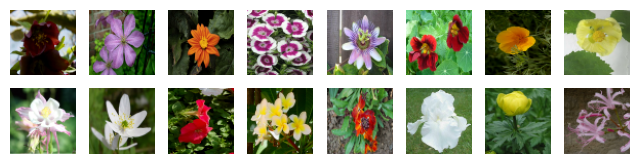

(16, 64, 64, 3)


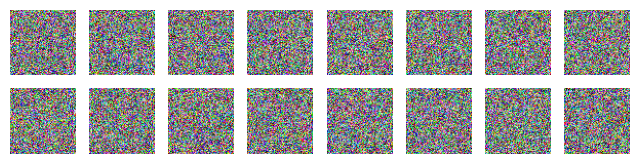

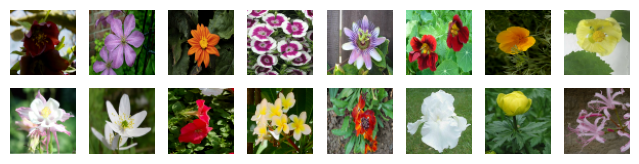

[]


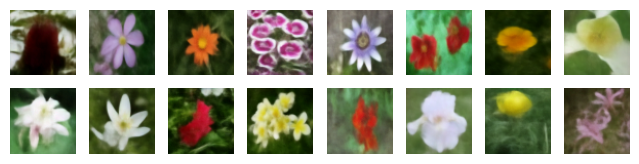

  0%|          | 0/999 [00:00<?, ?it/s]

[]


100%|██████████| 999/999 [00:17<00:00, 58.48it/s]


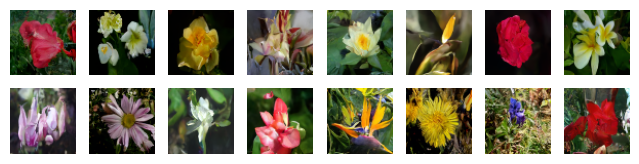

In [26]:
images = next(iter(data))
plotImages(images)
print(images.shape)
rng = jax.random.PRNGKey(4)
noise = jax.random.normal(rng, shape=images.shape, dtype=jnp.float32)
noise_level = 700
noise_levels = jnp.ones((images.shape[0],), dtype=jnp.int32) * noise_level
sampler = DDPMSampler(trainer.model, trainer.best_state.params, trainer.noise_schedule, model_output_transform=trainer.model_output_transform)
noise_schedule = trainer.noise_schedule
noisy_images = noise_schedule.add_noise(images, noise, noise_levels)
plotImages(noisy_images)
regenerated_images = noise_schedule.remove_all_noise(noisy_images, noise, noise_levels)
plotImages(regenerated_images)
pred = unet.apply(trainer.state.params, noisy_images, trainer.noise_schedule.transform_steps(noise_levels))
reconstructed_images, pred_noise =trainer.model_output_transform(noisy_images, pred, noise_levels, noise_schedule)
reconstructed_images = noise_schedule.clip_images(reconstructed_images)
plotImages(reconstructed_images)
samples = sampler.generate_images(num_images=BATCH_SIZE, start_step=999, priors=noisy_images)
plotImages(samples)

  0%|          | 0/100 [00:00<?, ?it/s]

[]


100%|██████████| 100/100 [00:09<00:00, 10.62it/s]


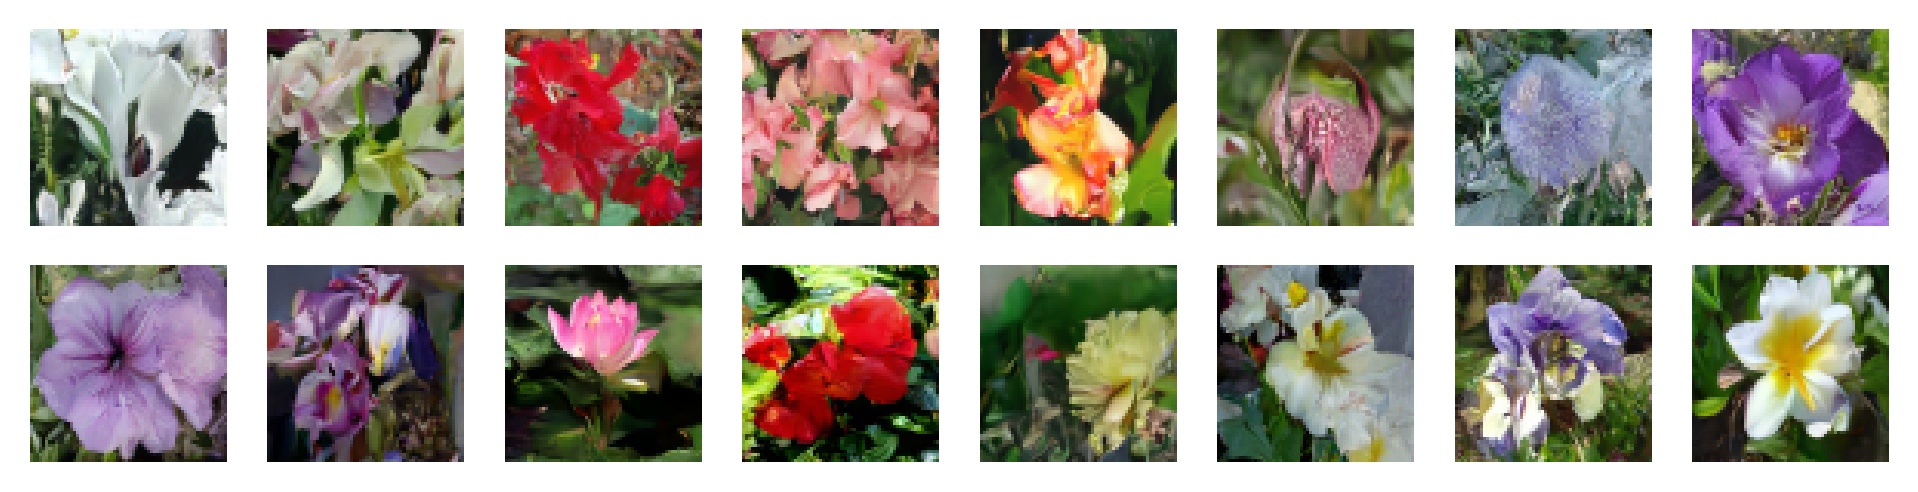

In [14]:
sampler = DDIMSampler(trainer.model, trainer.best_state.params, trainer.noise_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=16, diffusion_steps=100, priors=None)
plotImages(samples, dpi=300)

  0%|          | 0/1000 [00:00<?, ?it/s]

[]


100%|██████████| 1000/1000 [00:15<00:00, 65.72it/s]


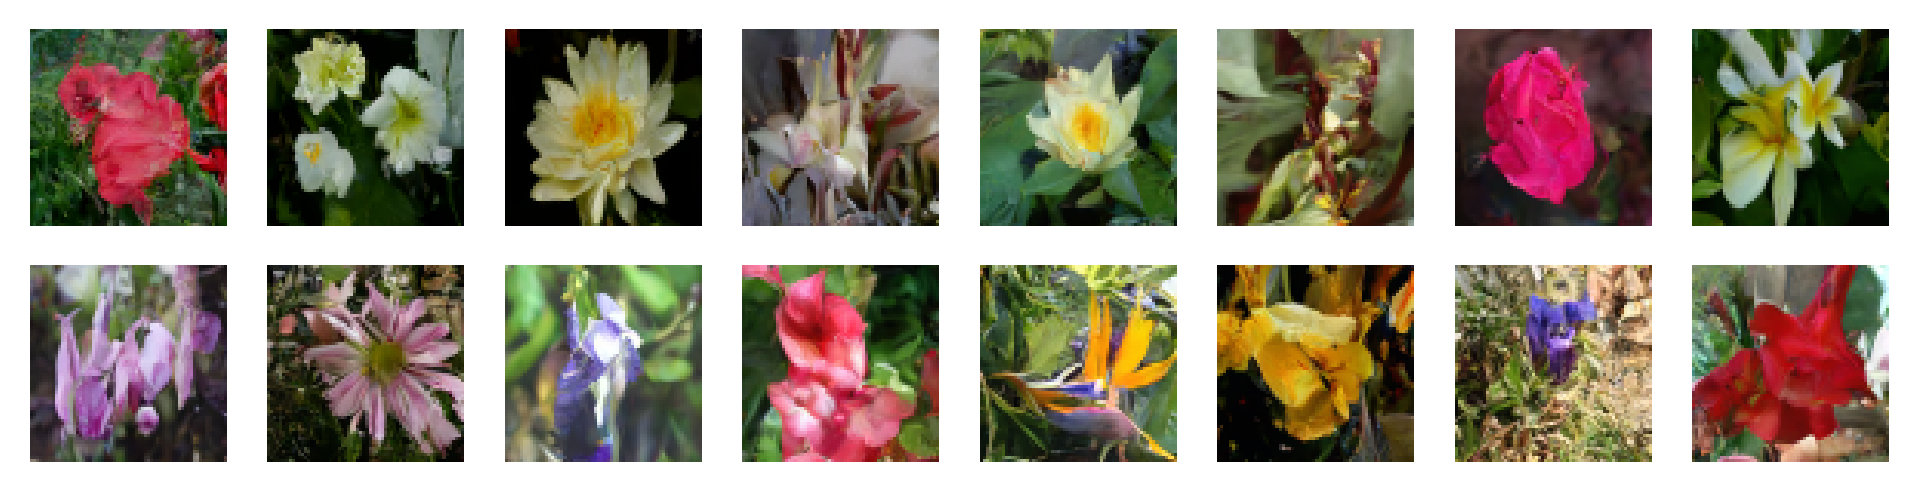

In [28]:
sampler = DDPMSampler(trainer.model, trainer.best_state.params, trainer.noise_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=16, start_step=1000, priors=None)
plotImages(samples, dpi=300)

  0%|          | 0/1000 [00:00<?, ?it/s]

[]


100%|██████████| 1000/1000 [00:56<00:00, 17.73it/s]


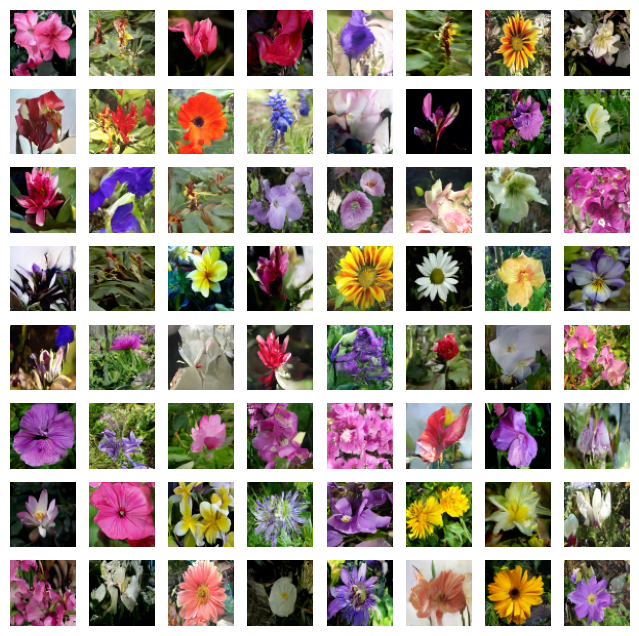

In [29]:
sampler = DDPMSampler(trainer.model, trainer.best_state.params, trainer.noise_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=64, start_step=1000, priors=None)
plotImages(samples)